#### Now that I have quick enough sampler for arDCA and Potts, I want to test their average Pearson correlation on test and train MSAs which have at least $1k$ proteins. We would like to extend this analysis also to ESM but their sampler currently is hideously slow as it generates one sample at the time. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys


sys.path.insert(1, "./../util")
sys.path.insert(1, "./../model")
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn
from pseudolikelihood import get_npll2, get_npll3
import torch, torchvision
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial

from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time


##Lucas computer
sys.path.insert(1, "/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
from Bio import SeqIO
from dynamic_loader import dynamic_collate_fn, dynamic_cluster
from torch.nn.functional import one_hot

from torch.nn.functional import softmax
from torch.distributions import Categorical


In [2]:
def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

q=21
embeddings = get_embedding(q)

In [3]:
max_msas = None
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/"

structure_test_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'test/structure'), encoding_dir, noise=0.0, max_msas=max_msas)
batch_structure_size_train = 1### I think with empty GPU we can go up to 16 easily
batch_structure_size=1
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples
batch_msa_size = 128 ### old is 32, original is 16
q = 21 ##isn't always 21
#dynamic_collate_fn

collate_fn = partial(dynamic_collate_fn, q=q, batch_size=batch_structure_size, batch_msa_size=batch_msa_size)
superfamily_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
num_workers=1, pin_memory=True)

/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/4xhyA00.encodings.pt Mismatch in dimension, skipping /home/luchinoprince/split2/test/structure/4xhyA00.a3m.pt


/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/tests/./../util/encoded_protein_dataset_new.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [4]:
### About half of the MSAs have at least 2k samples
structure_test_dataset.__len__()

993

In [5]:
structure_test_dataset.msas_paths[1:10]

['/home/luchinoprince/split2/test/structure/3eesA00.a3m.pt',
 '/home/luchinoprince/split2/test/structure/3e53A00.a3m.pt',
 '/home/luchinoprince/split2/test/structure/2dgsA01.a3m.pt',
 '/home/luchinoprince/split2/test/structure/5f7cA03.a3m.pt',
 '/home/luchinoprince/split2/test/structure/2dy3C02.a3m.pt',
 '/home/luchinoprince/split2/test/structure/1wn1A02.a3m.pt',
 '/home/luchinoprince/split2/test/structure/2b7jB01.a3m.pt',
 '/home/luchinoprince/split2/test/structure/6m8oA00.a3m.pt',
 '/home/luchinoprince/split2/test/structure/4mcwA02.a3m.pt']

In [1]:
device='cpu'
## This would work on windowsA
#bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'

bk_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Intermediate_Models/"
fname_par = 'model_11_07_2023_epoch_' + str(94.0) + '_ardca' + '.pt'
#fname_par = 'model_25_06_2023_epoch_' + str(94.0) + '.pt'
checkpoint = torch.load(os.path.join(bk_dir, fname_par))


q=21
args = checkpoint['args_run']
n_layers = args['n_layers']
param_embed_dim = d_model = args['param_embed_dim']
input_encoding_dim = args['input_encoding_dim']
n_heads=args['n_heads']
n_param_heads=args['n_param_heads']
dropout=args['dropout']

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout);
decoder.to(device);

decoder.load_state_dict(checkpoint['model_state_dict']);
decoder.eval();   ##to generate data we need just the forward pass of the model!

NameError: name 'torch' is not defined

In [7]:
Ns = torch.zeros(structure_test_dataset.__len__())
Ms = torch.zeros(structure_test_dataset.__len__())
corr_potts = torch.zeros(structure_test_dataset.__len__())
corr_ardca = torch.zeros(structure_test_dataset.__len__())
decoder.eval()

idx = 0
import warnings
warnings.filterwarnings("ignore")
with torch.no_grad():
    for inputs_packed in superfamily_test_loader:
        print(f"I am at index:{idx} out of {structure_test_dataset.__len__()}", end="\r")
        ### I have to understand how to recover the correct name of the file
        for inputs in inputs_packed[1]:
            msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
            B, M, N = msas.shape
            #if idx>5:
            #    break
            #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
            couplings, fields = decoder.forward_ardca(encodings, padding_mask)
            test_msa=torch.load(structure_test_dataset.msas_paths[idx]).to(torch.int)
            M_full = test_msa.shape[0]
            samples_ardca = decoder.sample_ardca_full(encodings, padding_mask, device='cpu', n_samples=M_full)
            
            samples_ardca=torch.tensor(samples_ardca.to('cpu'), dtype=torch.long)
            test_msa = torch.tensor(test_msa, dtype=torch.long)
            cov_train = compute_covariance(test_msa, q)
            cov_ardca = compute_covariance(samples_ardca, q)
            res = scipy.stats.pearsonr(cov_train.flatten(), cov_ardca.flatten())

            Ns[idx] = N
            Ms[idx] = test_msa.shape[0]
            corr_ardca[idx] = res[0]
            idx+=1


In [ ]:
res = {}
res['Ms'] = Ms
res['Ns'] = Ns
res['corr_ardca'] = corr_ardca

In [ ]:
#torch.save(res, "res_corr_ardca_structure.pkl")

In [43]:
Ns = torch.zeros(superfamily_test_dataset.__len__())
Ms = torch.zeros(superfamily_test_dataset.__len__())
corr_potts = torch.zeros(superfamily_test_dataset.__len__())
corr_ardca = torch.zeros(superfamily_test_dataset.__len__())
decoder.eval()

alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

idx = 0
import warnings
warnings.filterwarnings("ignore")
with torch.no_grad():
    for inputs_packed in superfamily_test_loader:
        #if idx>4:
        #    break
        print(f"I am at index:{idx} out of {superfamily_test_dataset.__len__()}", end="\r")
        ### I have to understand how to recover the correct name of the file
        for inputs in inputs_packed[1]:
            msas, encodings, padding_mask  = [input.to(device, non_blocking=True) for input in inputs]
            B, M, N = msas.shape
            #if idx>5:
            #    break
            #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
            couplings, fields = decoder(encodings, padding_mask)
            test_msa=torch.load(superfamily_test_dataset.msas_paths[idx]).to(torch.int)
            M_full = test_msa.shape[0]
            
            ## Save the model
            ## In this folder I will save the model in consideration, I won't save all of them due to memory
            #auxiliary_model_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Auxiliary_Potts'
            auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
            #auxiliary_model_dir = "."

            #B,N,_ = rep_padded.shape
            with open(os.path.join(auxiliary_model_dir, "potts_couplings_fields.txt"), "w") as f:
                ## write J
                for i in range(N):
                    for j in range(i+1, N):
                        for aa1 in range(q):
                            for aa2 in range(q):
                                J_el = couplings[0, i*q+aa1, j*q+aa2].detach().to('cpu').item()
                                line = "J " + str(i) + " " + str(j) + " "+ str(aa1) + " " + str(aa2) + " " + str(J_el) +"\n"
                                f.write(line)
                
                ## write h
                for i in range(N):
                    for aa in range(q):
                        h_el = fields[0, i*q+aa1].detach().to('cpu').item()
                        line = "h " + str(i) + " " + str(aa) + " " + str(h_el) + "\n"
                        f.write(line)
            ###### SAMPLE
            auxiliary_model_dir = "/home/luchinoprince/Auxiliary_Data_bmdca/"
            out_dir = '/home/luchinoprince/Auxiliary_Data_bmdca/Auxiliary_Samples_Potts/'
            out_file = 'samplesexp.txt'
            samples_path = os.path.join(auxiliary_model_dir, "potts_couplings_fields.txt")
            ## I generate a number of samples equal to the MSA, which we know is filtered to have at least 2k samples
            M_aux = int(np.ceil(M_full/10))
            ## The ! creates a terminal command, to pass variable you need to put square brackets
            !(bmdca_sample -p {samples_path} -n {M_aux} -d {out_dir} -o {out_file} -c bmdca.config)
            
            file='samplesexp_numerical.txt'
            with open(os.path.join(out_dir,file), mode='r') as f:
                lines=f.readlines()

            char_seq = [] ##36 is the lenght of YAP

            for i in range(1, len(lines)):
                line = lines[i][0:-1].split(" ") ## I take out the end of file
                line_char = [aa_index_inv[int(idx)] for idx in line]
                char_seq.append(line_char)
                
            ## Now re-translate
            for prot_idx in range(len(char_seq)):
                for aa in range(len(char_seq[prot_idx])):
                    char_seq[prot_idx][aa] = aa_index[char_seq[prot_idx][aa]]
                    
            msa_t = torch.tensor(char_seq, dtype=torch.long)
            cov_potts = compute_covariance(msa_t, 21)
            test_msa = torch.tensor(test_msa, dtype=torch.long)
            cov_train = compute_covariance(test_msa, q)
            res = scipy.stats.pearsonr(cov_train.flatten(), cov_potts.flatten())

            Ns[idx] = N
            Ms[idx] = test_msa.shape[0]
            corr_potts[idx] = res[0]
            ##### This way if the output gets cluttered I can still see where I am
            with open("tracker.txt", "w") as f:
                line = "fineshed " + str(idx) + "\n"
                f.write(line)
            idx+=1


initializing sampler... 5240.0932805 sec

sampling model with mcmc... 2.71109 sec
updating mcmc stats with samples... 0.169735 sec
computing sequence energies and correlations... 0.0342132 sec
increasing wait time to 1500
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 3.86664 sec
updating mcmc stats with samples... 0.357388 sec
computing sequence energies and correlations... 0.0698711 sec
increasing wait time to 2250
increasing burn-in time to 225000
maximum number of resamplings (1) reached. stopping...
writing final sequences... done
initializing sampler... 5240.0152678 sec

sampling model with mcmc... 0.202332 sec
updating mcmc stats with samples... 0.00580847 sec
computing sequence energies and correlations... 0.0279714 sec
increasing wait time to 1500
resampling...
writing temporary files
sampling model with mcmc... 0.234607 sec
updating mcmc stats with samples... 0.00880328 sec
computing sequence energies and correlations... 0.

In [44]:
res = {}
res['Ms'] = Ms
res['Ns'] = Ns
res['corr_potts'] = corr_potts

In [45]:
#torch.save(res, "res_corr_potts2.pkl")

#### Ok now that I have the files let us load the and compare them!

In [3]:
res_corr_ardca = torch.load("res_corr_ardca_structure.pkl")
res_corr_potts = torch.load("res_corr_potts_structure.pkl")

In [5]:
print(res_corr_potts['corr_potts'][0:7])
print(res_corr_ardca['corr_ardca'][0:7])


tensor([0.1354, 0.6501, 0.3947, 0.6805, 0.5271, 0.4152, 0.4637])
tensor([0.2242, 0.6741, 0.4142, 0.7749, 0.5020, 0.5791, 0.5461])


In [6]:
res_corr_ardca['corr_ardca'].mean()

tensor(0.5138)

In [8]:
res_corr_potts['corr_potts'].mean()

tensor(0.4240)

In [9]:
Ns = res_corr_potts['Ns']
Ms = res_corr_potts['Ms']

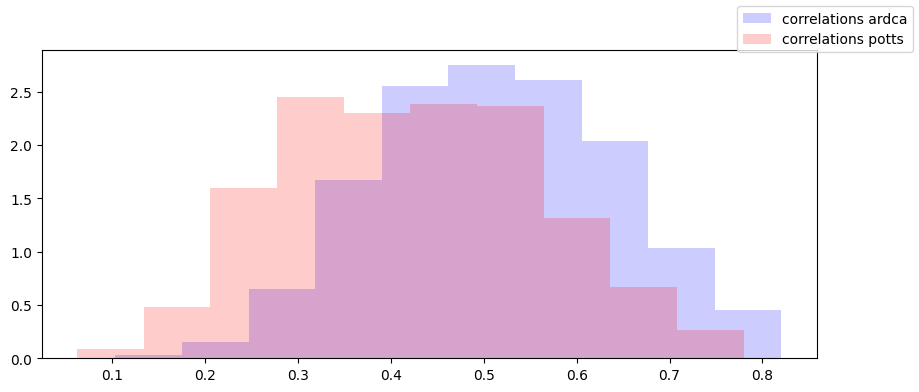

In [10]:
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.hist(res_corr_ardca['corr_ardca'], density=True, alpha=0.2, color="blue", label="correlations ardca")
ax.hist(res_corr_potts['corr_potts'], density=True, alpha=0.2, color="red", label="correlations potts")
fig.legend()

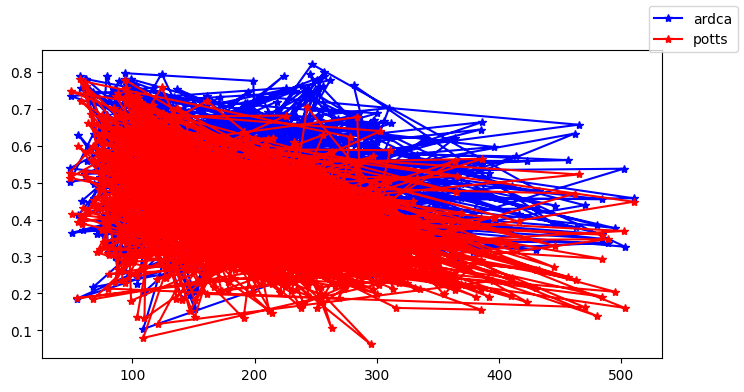

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4))
ax.plot(Ns, res_corr_ardca['corr_ardca'], color="blue", marker="*", linestyle="-", label="ardca")
ax.plot(Ns, res_corr_potts['corr_potts'], color="red", marker="*", linestyle="-", label="potts")
fig.legend()

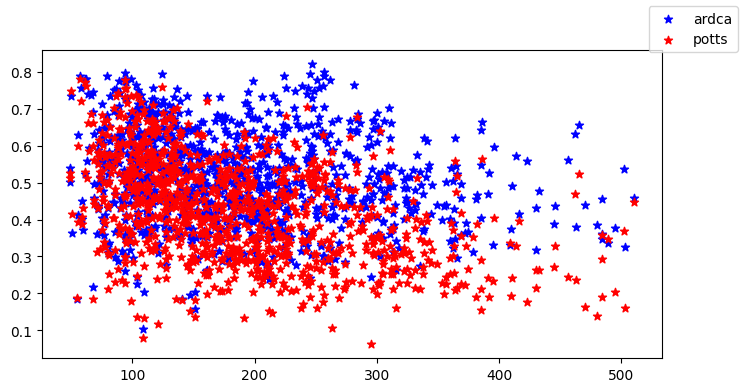

In [12]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4))
ax.scatter(Ns, res_corr_ardca['corr_ardca'], color="blue", marker="*", label="ardca")
ax.scatter(Ns, res_corr_potts['corr_potts'], color="red", marker="*", label="potts")
fig.legend()

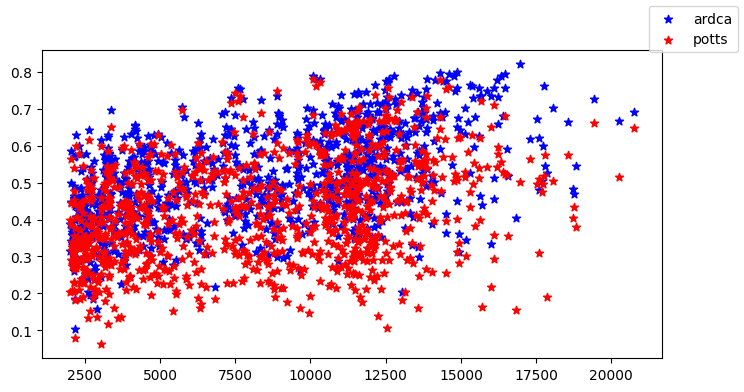

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=1, figsize=(8,4))
ax.scatter(Ms, res_corr_ardca['corr_ardca'], color="blue", marker="*", label="ardca")
ax.scatter(Ms, res_corr_potts['corr_potts'], color="red", marker="*", label="potts")
fig.legend()

In [6]:
import seaborn as sns

In [18]:
res_corr_ardca_structure = torch.load("res_corr_ardca_structure.pkl")
res_corr_potts_structure = torch.load("res_corr_potts_structure.pkl")
res_corr_esm_structure = torch.load("res_corr_esm_structure.pkl")

res_corr_ardca_superfamily = torch.load("res_corr_ardca_superfamily.pkl")
res_corr_potts_superfamily = torch.load("res_corr_potts_superfamily.pkl")

<Axes: title={'center': 'Correlations vs MSA size potts'}>

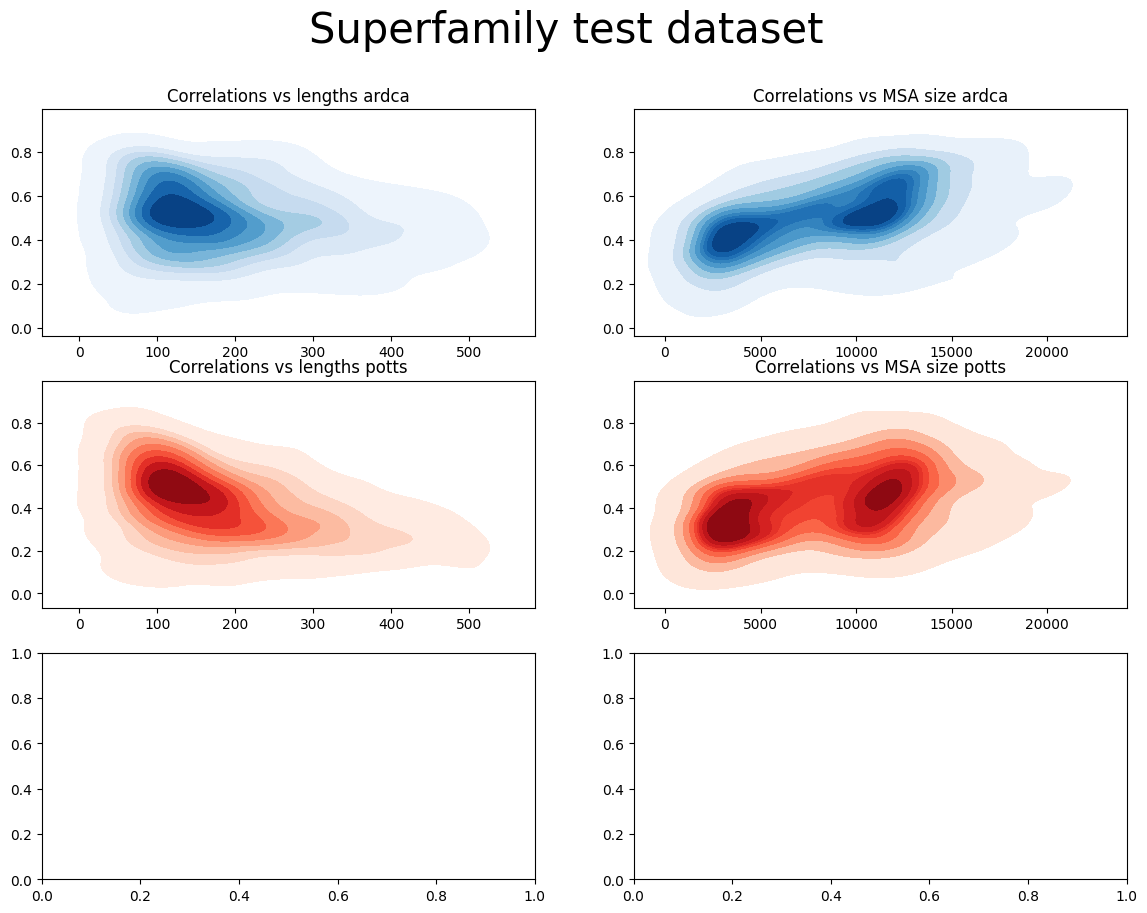

In [15]:
Ns = res_corr_potts_superfamily['Ns']
Ms = res_corr_potts_superfamily['Ms']

fig, ([[ax1, ax2], [ax3,ax4], [ax5,ax6]]) = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle("Superfamily test dataset", size=30)
ax1.set_title('Correlations vs lengths ardca')
ax3.set_title('Correlations vs lengths potts')
ax2.set_title('Correlations vs MSA size ardca')
ax4.set_title('Correlations vs MSA size potts')
#ax5.set_title('Correlations vs lengths esm')
#ax6.set_title('Correlations vs MSA size esm')


sns.kdeplot(x=Ns, y=res_corr_ardca_superfamily['corr_ardca'], cmap='Blues', fill=True, thresh=0.01, ax=ax1)
sns.kdeplot(x=Ns, y=res_corr_potts_superfamily['corr_potts'], cmap='Reds', fill=True, thresh=0.01, ax=ax3)
sns.kdeplot(x=Ms, y=res_corr_ardca_superfamily['corr_ardca'], cmap='Blues', fill=True, thresh=0.01, ax=ax2)
sns.kdeplot(x=Ms, y=res_corr_potts_superfamily['corr_potts'], cmap='Reds', fill=True, thresh=0.01, ax=ax4)
#sns.kdeplot(x=Ns, y=res_corr_ardca_superfamily['corr_ardca'], cmap='Blues', fill=True, thresh=0.01, ax=ax2)
#sns.kdeplot(x=Ms, y=res_corr_potts_superfamily['corr_potts'], cmap='Reds', fill=True, thresh=0.01, ax=ax4)
#sns.kdeplot(x=F3, y=N3, cmap='Greens', fill=True, thresh=0.02, ax=ax1)
#sns.kdeplot(x=F4, y=N4, cmap='Purples', fill=True, thresh=0.02, ax=ax1)

## To directly compare we have can do the same plots but looking at differences

<Axes: title={'center': 'Delta Correlations vs MSA size'}>

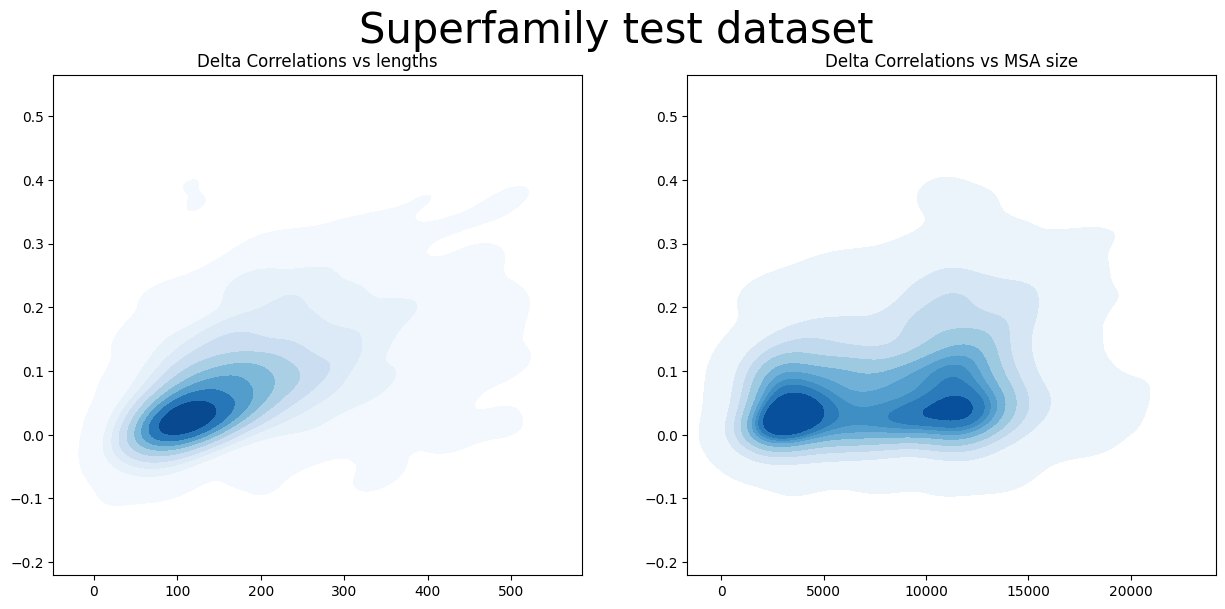

In [24]:
fig, ([ax1, ax2]) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6.5))
fig.suptitle("Superfamily test dataset", size=30)
ax1.set_title('Delta Correlations vs lengths')
ax2.set_title('Delta Correlations vs MSA size')

sns.kdeplot(x=Ns, y=res_corr_ardca_superfamily['corr_ardca']-res_corr_potts_superfamily['corr_potts'], cmap='Blues', fill=True, thresh=0.01, ax=ax1)
sns.kdeplot(x=Ms, y=res_corr_ardca_superfamily['corr_ardca']-res_corr_potts_superfamily['corr_potts'], cmap='Blues', fill=True, thresh=0.01, ax=ax2)
#sns.kdeplot(x=F3, y=N3, cmap='Greens', fill=True, thresh=0.02, ax=ax1)
#sns.kdeplot(x=F4, y=N4, cmap='Purples', fill=True, thresh=0.02, ax=ax1)

#### Now let us move to the structure test dataset

<Axes: title={'center': 'Correlations vs MSA size esm'}>

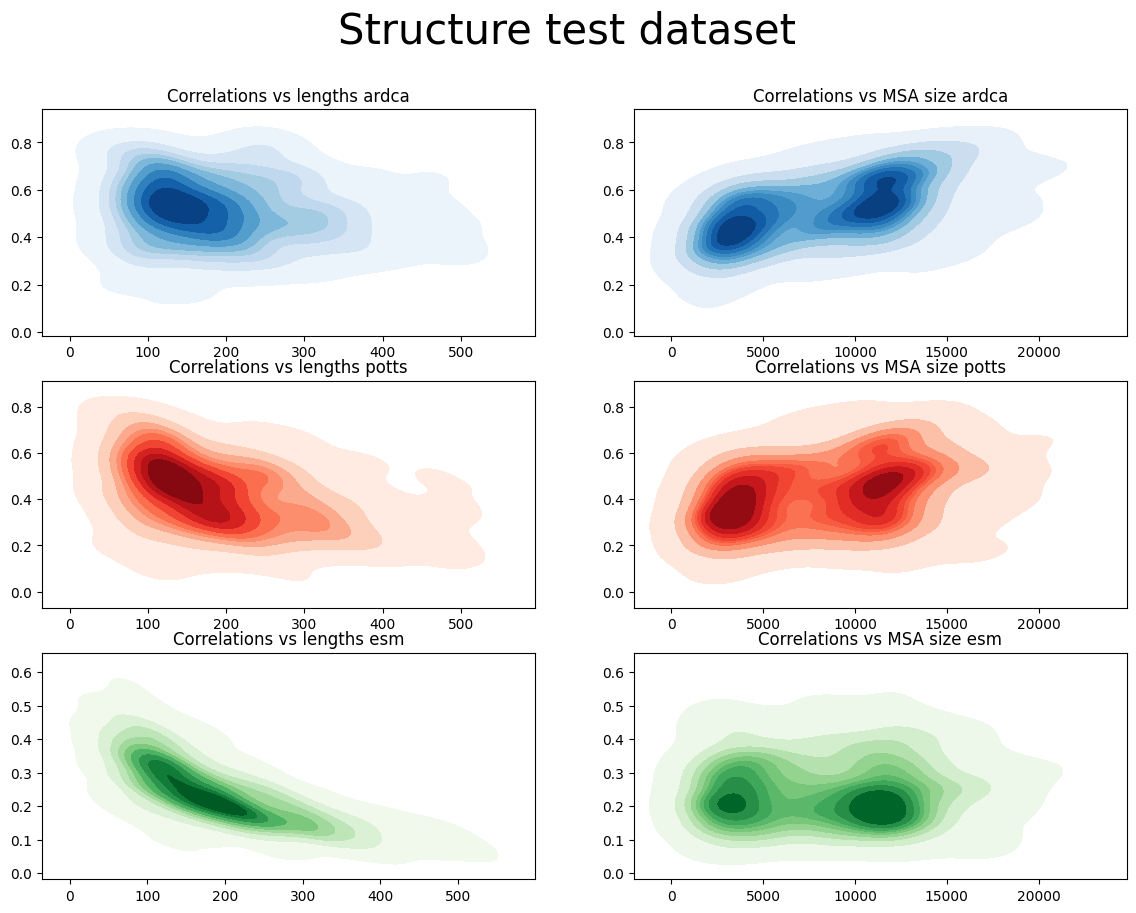

In [27]:
Ns = res_corr_potts_structure['Ns']
Ms = res_corr_potts_structure['Ms']

### I don't know why they are one longer... 
Ms_esm = res_corr_esm_structure['Ms']
Ns_esm = res_corr_esm_structure['Ns']

fig, ([[ax1, ax2], [ax3,ax4], [ax5,ax6]]) = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
fig.suptitle("Structure test dataset", size=30)
ax1.set_title('Correlations vs lengths ardca')
ax3.set_title('Correlations vs lengths potts')
ax2.set_title('Correlations vs MSA size ardca')
ax4.set_title('Correlations vs MSA size potts')
ax5.set_title('Correlations vs lengths esm')
ax6.set_title('Correlations vs MSA size esm')

sns.kdeplot(x=Ns, y=res_corr_ardca_structure['corr_ardca'], cmap='Blues', fill=True, thresh=0.01, ax=ax1)
sns.kdeplot(x=Ns, y=res_corr_potts_structure['corr_potts'], cmap='Reds', fill=True, thresh=0.01, ax=ax3)
sns.kdeplot(x=Ms, y=res_corr_ardca_structure['corr_ardca'], cmap='Blues', fill=True, thresh=0.01, ax=ax2)
sns.kdeplot(x=Ms, y=res_corr_potts_structure['corr_potts'], cmap='Reds', fill=True, thresh=0.01, ax=ax4)
sns.kdeplot(x=Ns_esm, y=res_corr_esm_structure['corr_esm'], cmap='Greens', fill=True, thresh=0.01, ax=ax5)
sns.kdeplot(x=Ms_esm, y=res_corr_esm_structure['corr_esm'], cmap='Greens', fill=True, thresh=0.01, ax=ax6)

<Axes: title={'center': 'Delta Correlations vs MSA size'}>

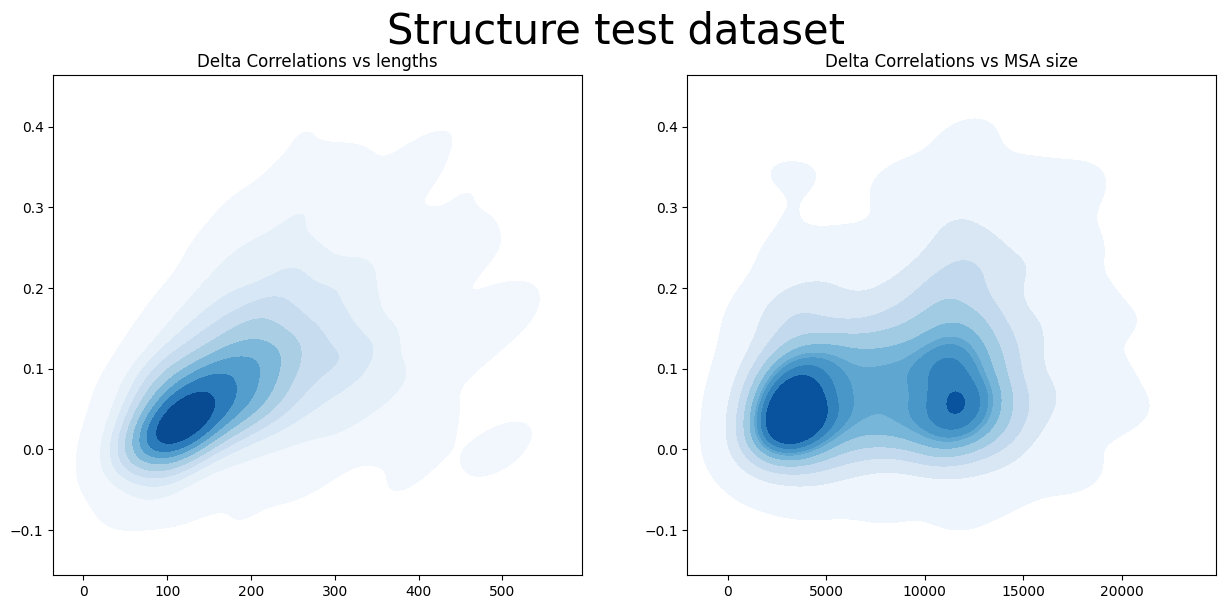

In [27]:
fig, ([ax1, ax2]) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6.5))
fig.suptitle("Structure test dataset", size=30)
ax1.set_title('Delta Correlations vs lengths')
ax2.set_title('Delta Correlations vs MSA size')

sns.kdeplot(x=Ns, y=res_corr_ardca_structure['corr_ardca']-res_corr_potts_structure['corr_potts'], cmap='Blues', fill=True, thresh=0.01, ax=ax1)
sns.kdeplot(x=Ms, y=res_corr_ardca_structure['corr_ardca']-res_corr_potts_structure['corr_potts'], cmap='Blues', fill=True, thresh=0.01, ax=ax2)
